# Procedure for image preprocessing

## Setup

In [1]:
# %load_ext nb_black
# %matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import cv2
from PIL import ImageStat
import random
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
os.environ.get("TRAINING_DIRECTORY")

'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light'

## Define constants and read the data

In [3]:
# Set the path to the folders containing the images
# train_dir = './training_data/'
train_dir = os.environ.get("TRAINING_DIRECTORY")

# Define the image size
img_height = 1024
img_width = 1024


In [4]:
# Read in the images and resize them
classes = ["healthy", "infected"]
images = []
labels = []
img_paths = []
img_dir = f"{train_dir}/mini-healthy"
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
    )
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(0)
    img_paths.append(path)

img_dir = f"{train_dir}/mini-infected"
for img_file in os.listdir(img_dir):
    path = os.path.join(img_dir, img_file)
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(img_height, img_width)
    )
    img = tf.keras.preprocessing.image.img_to_array(img, dtype=np.uint8)
    images.append(img)
    labels.append(1)
    img_paths.append(path)

# Convert the data and labels to NumPy arrays
images = np.array(images)
labels = np.array(labels)
img_paths = np.array(img_paths)

In [5]:
images.shape

(300, 1024, 1024, 3)

## Store some information about the dataset into a Dataframe

- The cucumber image is masked (where the BLUE channel is below some threshold to filter out the background)
- The first row is found where the mask contains at least 1/64 true values (sorting out possible single pixels that were not filtered out)
    - This is considered the start y-pixel-coordinate of the cucumber
- From there search the first row where there are less than 1/64 true values
    - This is considered the end y-pixel-coordinate of the cucumber 
- Same process is repeated for columns to get the x-pixel-coordinates


In [6]:
# Map all images to their blue channel and flatten them
# images_blue_flattened = []
# for image in images:
#     images_blue_flattened.append(images[0][:, :, 2].ravel())
# images_blue_flattened = np.array(images_blue_flattened)
# print(f'Shape: {images_blue_flattened.shape}')

# -- Plot the average number of blue pixels per image --
# mean = np.median(images_blue_flattened, axis=0)
# plt.hist(mean, bins=int(255/5))

# -- Use the histogram to find the threshold for masking the background --

In [7]:
# Get the first y-pixel value where at least 1/64 of the pixels are masked
MASK_BLUE_THRESHOLD = 130


def get_first_and_last_cucumber_pixel(image):
    # masked_img = image[..., 2] < MASK_BLUE_THRESHOLD

    (_, masked_img) = cv2.threshold(
        image[..., 2], MASK_BLUE_THRESHOLD, 1, cv2.THRESH_BINARY_INV)

    first_cucumber_pixel_y = None
    last_cucumber_pixel_y = None
    threshold_height = img_height / 64
    for i in range(masked_img.shape[0]):
        if np.sum(masked_img[i, :]) > threshold_height:
            first_cucumber_pixel_y = i
            j = first_cucumber_pixel_y
            for j in range(i, masked_img.shape[0]):
                if np.sum(masked_img[j, :]) <= threshold_height:
                    last_cucumber_pixel_y = j
                    break
            break

    first_cucumber_pixel_x = None
    last_cucumber_pixel_x = None
    threshold_width = 2
    threshold_min_width = img_width / 16
    for i in range(masked_img.shape[1]):
        if np.sum(masked_img[:, i]) > threshold_width:
            first_cucumber_pixel_x = i
            for j in range(first_cucumber_pixel_x, masked_img.shape[0]):
                if np.sum(masked_img[:, j]) <= threshold_width and j - first_cucumber_pixel_x > threshold_min_width:
                    last_cucumber_pixel_x = j
                    break
            break

    return (
        (first_cucumber_pixel_x, first_cucumber_pixel_y),
        (last_cucumber_pixel_x, last_cucumber_pixel_y),
    )

In [8]:
# Create the DataFrame

df_records = []
for i in range(images.shape[0]):
    ((first_x, first_y), (last_x, last_y)) = get_first_and_last_cucumber_pixel(
        images[i]
    )
    df_records.append(
        {
            "idx": i,
            "label": classes[labels[i]],
            "first_cucumber_pixel_y": first_y,
            "last_cucumber_pixel_y": last_y,
            "first_cucumber_pixel_x": first_x,
            "last_cucumber_pixel_x": last_x,
            "cucumber_height": last_y - first_y,
            "cucumber_width": last_x - first_x,
        }
    )

df = pd.DataFrame(df_records)

print(df)

     idx     label  first_cucumber_pixel_y  last_cucumber_pixel_y  \
0      0   healthy                     333                    572   
1      1   healthy                     331                    565   
2      2   healthy                     327                    609   
3      3   healthy                     352                    570   
4      4   healthy                     324                    558   
..   ...       ...                     ...                    ...   
295  295  infected                     311                    643   
296  296  infected                     311                    558   
297  297  infected                     332                    581   
298  298  infected                     311                    581   
299  299  infected                     349                    636   

     first_cucumber_pixel_x  last_cucumber_pixel_x  cucumber_height  \
0                       163                    848              239   
1                       151  

## Plot some random images from the dataset with their label and a box around the cucumber using the detected cucumber pixels calculated in the above Dataframe

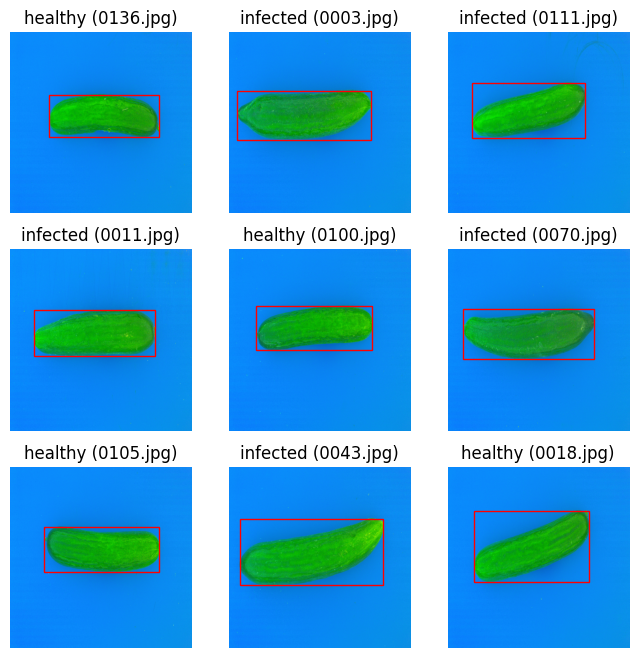

In [9]:
def plot_cucumbers_with_boxes(images, df, classes, labels, img_paths):
    # Plot some random images with their label and a line for the first "cucumber pixel" detected
    plt.figure(figsize=(8, 8))
    # rand = random.randint(0, images.shape[0] - 10)
    for i in range(9):
        rand_idx = random.randint(0, images.shape[0] - 1)
        # rand_idx = rand + i
        # rand_idx = 25 + i
        ax = plt.subplot(3, 3, i + 1)
        rect = patches.Rectangle(
            (
                df.iloc[rand_idx]["first_cucumber_pixel_x"],
                df.iloc[rand_idx]["first_cucumber_pixel_y"],
            ),
            df.iloc[rand_idx]["last_cucumber_pixel_x"]
            - df.iloc[rand_idx]["first_cucumber_pixel_x"],
            df.iloc[rand_idx]["last_cucumber_pixel_y"]
            - df.iloc[rand_idx]["first_cucumber_pixel_y"],
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )

        ax.add_patch(rect)
        plt.imshow(images[rand_idx])
        path = img_paths[rand_idx].split(os.sep)[-1]
        plt.title(f"{classes[labels[rand_idx]]} ({path})")
        plt.axis("off")


plot_cucumbers_with_boxes(images, df, classes, labels, img_paths)


In [10]:
def remove_image_background(image):
    (_, masked_img) = cv2.threshold(
        image[..., 2], MASK_BLUE_THRESHOLD, 1, cv2.THRESH_BINARY_INV)
    # masked_img = image[..., 2] < MASK_BLUE_THRESHOLD

    img_mask_reshaped = np.zeros((*masked_img.shape, 3))
    img_mask_reshaped[np.where(masked_img)] = [1, 1, 1]

    return np.multiply(image, img_mask_reshaped).astype(np.uint8)

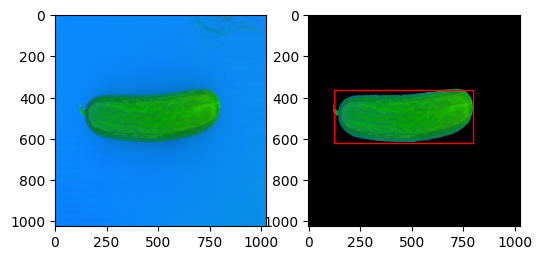

In [11]:
def plot_cucumber_without_bg(images, df):
    idx = random.randint(0, images.shape[0] - 1)
    image = images[idx]

    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    ax = plt.subplot(1, 2, 2)
    rect = patches.Rectangle(
        (df.iloc[idx]["first_cucumber_pixel_x"], df.iloc[idx]["first_cucumber_pixel_y"]),
        df.iloc[idx]["last_cucumber_pixel_x"] - df.iloc[idx]["first_cucumber_pixel_x"],
        df.iloc[idx]["last_cucumber_pixel_y"] - df.iloc[idx]["first_cucumber_pixel_y"],
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )

    ax.add_patch(rect)
    plt.imshow(remove_image_background(image))
    plt.show()


plot_cucumber_without_bg(images, df)


In [12]:
print(f'Images infected: {(len(df[df["label"]=="infected"]))}')
print(f'Images healthy: {(len(df[df["label"]=="healthy"]))}')

Images infected: 144
Images healthy: 156


In [13]:
df_sorted_by_height = df.sort_values("cucumber_height", ascending=False)
img_paths[df_sorted_by_height["idx"][:10]]

array(['F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-infected\\0123.jpg',
       'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-infected\\0127.jpg',
       'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-infected\\0131.jpg',
       'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-infected\\0120.jpg',
       'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-healthy\\0132.jpg',
       'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-infected\\0136.jpg',
       'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-healthy\\0143.jpg',
       'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-healthy\\0133.jpg',
       'F:/big-data/uni/minor-a-systems/cucumber-dataset-compressed/normal-light/mini-infected\\0135.jpg',
       'F:/big-data/uni/minor-a-systems/

In [14]:
img_paths[df[df["first_cucumber_pixel_y"] < 4]["idx"]]

array([], dtype='<U95')

In [15]:
img_paths[df[df["last_cucumber_pixel_y"] > img_height - 4]["idx"]]

array([], dtype='<U95')

In [16]:
idx = random.randint(0, images.shape[0] - 1)
image = remove_image_background(images[idx])
df_entry = df.iloc[idx]

def crop_both_cucumber_tips(image, df_entry):
    total_height = df_entry["cucumber_height"]
    total_width = df_entry["cucumber_width"]

    if total_height > total_width:
        raise ValueError("Cucumber height is bigger than width")

    # Crop images to both tips
    img_left = image[
        df_entry["first_cucumber_pixel_y"] : df_entry["last_cucumber_pixel_y"],
        df_entry["first_cucumber_pixel_x"] : df_entry["first_cucumber_pixel_x"]
        + total_height,
    ]

    img_right = image[
        df_entry["first_cucumber_pixel_y"] : df_entry["last_cucumber_pixel_y"],
        df_entry["last_cucumber_pixel_x"]
        - total_height : df_entry["last_cucumber_pixel_x"],
    ]

    img_left = cv2.resize(src=img_left, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

    img_right = cv2.resize(src=img_right, dsize=(
        224, 224), interpolation=cv2.INTER_CUBIC)
    
    return (img_left, img_right)


img_left, img_right = crop_both_cucumber_tips(image, df_entry)

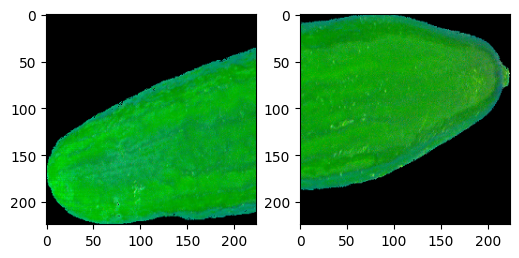

In [17]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_left, cmap=plt.get_cmap("gray"))
plt.subplot(2, 2, 2)
plt.imshow(img_right, cmap=plt.get_cmap("gray"))

plt.show()

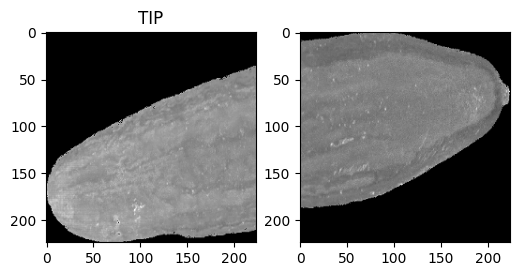

In [18]:
# Testing if tip side can be determined by using average grayscale value

img_left_gray = np.dot(img_left[..., :], [0.2989, 0.5870, 0.1140])
img_right_gray = np.dot(img_right[..., :], [0.2989, 0.5870, 0.1140])

mean_brightness_left = np.mean(img_left_gray, axis=None)
mean_brightness_right = np.mean(img_right_gray, axis=None)

plt.figure(figsize=(6, 6))
plt.subplot(2, 2, 1)
plt.imshow(img_left_gray, cmap=plt.get_cmap("gray"))
if mean_brightness_left > mean_brightness_right:
    plt.title("TIP")

plt.subplot(2, 2, 2)
plt.imshow(img_right_gray, cmap=plt.get_cmap("gray"))
if mean_brightness_right > mean_brightness_left:
    plt.title("TIP")


plt.show()

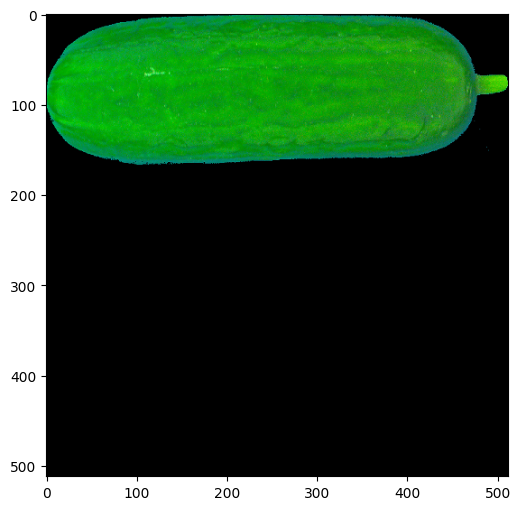

In [19]:
idx = random.randint(0, images.shape[0] - 1)
image = remove_image_background(images[idx])
df_entry = df.iloc[idx]

def crop_cucumber(image, df_entry, idx):
    total_height = df_entry["cucumber_height"]
    total_width = df_entry["cucumber_width"]

    cucumber_size = total_width

    if total_height > total_width:
        print(f'Cucumber height > width at image: {idx}')
        cucumber_size = total_height
        # raise ValueError("Cucumber height is bigger than width")

    # Crop images to both sides
    image = image[
        df_entry["first_cucumber_pixel_y"]: df_entry["first_cucumber_pixel_y"] + cucumber_size,
        df_entry["first_cucumber_pixel_x"]: df_entry["first_cucumber_pixel_x"] + cucumber_size,
    ]

    # print(f'Cropped img shape {image.shape}')

    image = cv2.resize(src=image, dsize=(512, 512),
                       interpolation=cv2.INTER_CUBIC)
    return image


image = crop_cucumber(image, df_entry, idx)
plt.figure(figsize=(6, 6))
plt.imshow(image)

In [20]:
final_data = []
for (idx, image) in enumerate(images):
    image = remove_image_background(image)
    image = crop_cucumber(image, df.iloc[idx], idx)
    final_data.append(image)


final_data = np.array(final_data)
final_data = final_data.astype('float32') / 255
final_data.shape

Cucumber height > width at image: 277
Cucumber height > width at image: 278


(300, 512, 512, 3)

idx                           153
label                     healthy
first_cucumber_pixel_y        255
last_cucumber_pixel_y         635
first_cucumber_pixel_x        165
last_cucumber_pixel_x         810
cucumber_height               380
cucumber_width                645
Name: 153, dtype: object


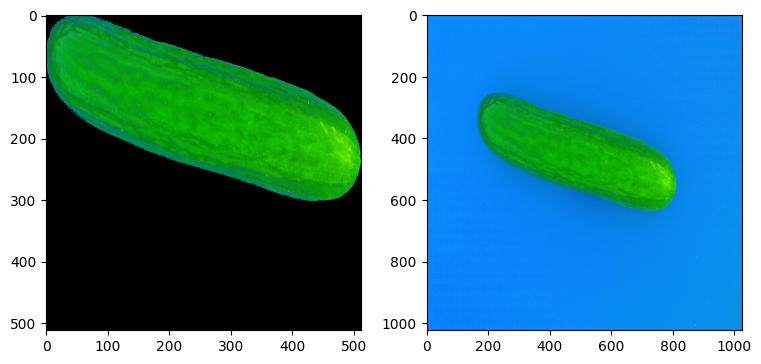

In [28]:
i = random.randint(0, images.shape[0] - 1)

print(df.iloc[i])
plt.figure(figsize=(9, 9))
plt.subplot(2, 2, 1)
plt.imshow(final_data[i])
plt.subplot(2, 2, 2)
plt.imshow(images[i])

## AI Training
In the following section the pre_processed images stored in `final_data` are used to train an AI model

In [29]:
from sklearn.model_selection import train_test_split
from keras.applications import VGG16

num_classes = 2
num_epochs = 8
batch_size = 32
input_shape = (final_data.shape[1], final_data.shape[2], final_data.shape[3])

# Split data into training and validation data
x_train, x_valid, y_train, y_valid = train_test_split(
    final_data, labels, test_size=0.2, shuffle=True)

print(f'Train: {x_train.shape} | {y_train.shape} Validation: {x_valid.shape} | {y_valid.shape}')

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Define the model architecture
model = keras.Sequential([
    base_model,
    # keras.layers.Conv2D(32, (3, 3), activation='relu'),
    # keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
            #   metrics=[
            #       'accuracy'
            #   ])
              metrics=[
                  keras.metrics.Accuracy(),
                  keras.metrics.Recall(),
                  keras.metrics.Precision(),
                  keras.metrics.AUC()
              ])

# Train the model
model.fit(x_train, y_train, epochs=num_epochs,
          batch_size=batch_size, validation_data=(x_valid, y_valid))



Train: (240, 512, 512, 3) | (240,) Validation: (60, 512, 512, 3) | (60,)
Epoch 1/8
8/8 [==============================] - 76s 6s/step - loss: 7.5492 - accuracy: 0.1333 - recall: 0.4348 - precision: 0.4854 - auc: 0.4960 - val_loss: 0.8662 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.6869
Epoch 2/8
8/8 [==============================] - 6s 795ms/step - loss: 0.7606 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.5098 - val_loss: 0.6932 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 3/8
8/8 [==============================] - 6s 819ms/step - loss: 0.6932 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.4957 - val_loss: 0.6932 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000
Epoch 4/8
8/8 [==============================] - 6s 841ms/step - loss: 0.6931 - accuracy: 0.0000e+00 - recall:

In [30]:
# Get predicted labels for the validation data
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_valid)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Print the confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print("Confusion matrix:")
print(y_valid)
print(y_pred)
print(cm)


2/2 [==============================] - 1s 448ms/step
Confusion matrix:
[1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0
 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[31  0]
 [29  0]]
